In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count, Sum
sys.path.append('/home/galm/software/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.forms.models import model_to_dict

from scoping.models import *
from tmv_app.models import *

run_id = 96
qid = 1053

In [2]:
docs = Doc.objects.filter(query=qid)

In [10]:
tvalues = []
for d in docs:
    
    ns = [x for x in re.findall("([2-3{m}][0-9]{3})",d.content) if int(x) > 2017]
    if len(ns) > 0:
        t = d.doctopic_set.filter(run_id=96).order_by('-score').first()
        for n in ns:
            v = {
                "doc" : d.UT,
                "topic" : t.topic.title,
                "number" : n
            }
            tvalues.append(v)
        

In [11]:
df = pd.DataFrame.from_dict(list(tvalues))
df.head()

,doc,number,topic
0,WOS:000389321500008,2050,"{polici, develop, plan}"
1,WOS:000393051100002,2020,"{polici, develop, plan}"
2,WOS:000383811000110,2021,"{emiss, carbon, ghg}"
3,WOS:000388153500007,2020,"{build, energi, perform}"
4,WOS:000388153500007,2030,"{build, energi, perform}"


In [44]:
pdf = df[['topic','number']]
#pdf.set_index('topic')
pdf['number'] = pd.to_numeric(pdf['number'])



/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


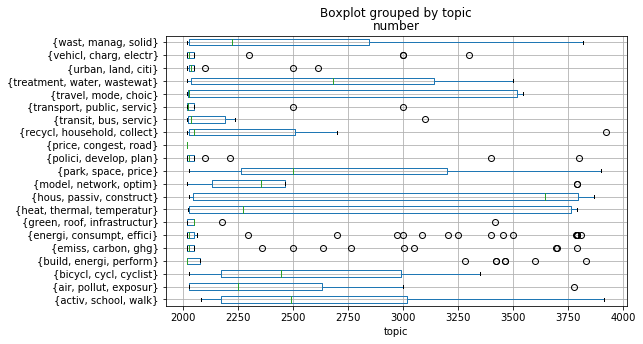

In [52]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [8,5]
pdf.boxplot(column='number', by='topic', vert=False)
plt.savefig('../plots/topic_years.png',bbox_inches='tight')  
plt.show()

In [47]:
pdf.dtypes

topic     object
number     int64
dtype: object